In [2]:
import pandas as pd
import os
import re
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

# Create initial datasets

### Setup input/output

In [3]:
# set base directory
baseDIR = os.path.dirname(os.getcwd())

# set input directory
inDIR = 'data/'

# set output directory
outDIR = 'data/clip'
if not os.path.exists(os.path.join(baseDIR, outDIR)):
    os.mkdir(os.path.join(baseDIR, outDIR))

# set input file
inXLSX = os.path.join(baseDIR, inDIR, 'TB_BiomassWeights14Jan2016_FINAL.xlsx')
inXLSX_sr = os.path.join(baseDIR, inDIR, 'TBClipping 123115_FINAL.xlsx')
# NOTE: data originally stored in: T:\2-Projects\Thunder Basin\In-Out Fire Transects(2014-2015)\2015\DataEntry\BiomassData\Final

# set location file
inSHP = os.path.join(baseDIR, inDIR, 'shps', 'ThunderBasin_Transects_sampled2014-2015.shp')
# NOTE: data originally stored in: T:\3-GIS\ThunderBasin\Fire_Transects\In_Out_Transects\ThunderBasin_Transects_sampled2014-2015.shp

# set size of clipping quadrat for calculating biomass density
quad_size_m2 = 0.5

In [4]:
# ok - did not get to all of them.
fire_id_dict = {'1937 Fire': '1937 fire',
                '1974 Fire': '1974 fire',
                '35 Mile Marker': '35 mile marker', 
                'Artisian': np.nan,
                'Beckwith 2006': 'beckwith 2006', 
                'Beckwith 2011': 'beckwith 2011', 
                'Borgailli': 'borgailli',
                'Cheyenne River 2003': 'cheyenne river 2003',
                'Cheyenne River 2006': 'cheyenne river 2006', 
                'Cowger': np.nan, 
                'Cummings': 'cummings',
                'Dry Creek Fire F': 'dry creek', 
                'Dry Fork': 'dry fork', 
                'East Riehle': 'east riehle', 
                'Keeline RA': 'keeline ra',
                'Kuemmerle': 'kuemmerle',
                'Lake Creek': 'lake creek',
                'Mush Creek': np.nan, 
                'North Edwards': np.nan,
                'Peterson Elliot': 'peterson elliot',
                'Peterson Elliott': 'peterson elliot', 
                'Phillips': 'phillips',
                'Rat Creek Fire': 'rat creek',
                'Rochelle Hills 2': 'rochelle hills',
                'South Cow': 'south cow', 
                'South Edwards': np.nan,
                'Steckley': 'steckley',
                'Stinson': np.nan, 
                'Tena Creek Fire': 'tena creek', 
                'Tepee': 'tepee', 
                'Wade Hill': np.nan,
                'West Fork Creek': 'west fork', 
                'Wildcat': 'wildcat',
                'peterson elliot 1': 'peterson elliot', #SR correction
                'philips': 'phillips', #BM correction
                'steckely': 'steckley' #BM correction
               }

### Load data

In [5]:
# create an Excel file object for investigating contents
fire_xlsx = pd.ExcelFile(os.path.join(baseDIR, inDIR, inXLSX))
fire_sr_xlsx = pd.ExcelFile(os.path.join(baseDIR, inDIR, inXLSX_sr))

# display the sheet names in the .xlsx file
display(fire_xlsx.sheet_names)
display(fire_sr_xlsx.sheet_names)

['BiomassData',
 'BiomassData2',
 'Checklist-Sorting',
 'Weighting Datasheet',
 'Summary_by_transect']

['Annual Bromes Cover', 'Shrub Volume', 'Notes']

In [33]:
# load necessary data
df_fire_bm = fire_xlsx.parse(sheet_name='BiomassData2', header=0)
df_fire_sr = fire_sr_xlsx.parse(sheet_name='Shrub Volume', header=0)
gdf_fire = gpd.read_file(inSHP)

In [38]:
gdf_fire[(gdf_fire['Fire'] == '35 Mile Marker')]

,Name,Id,Fire,Date,Inside,Eco,geometry
38,None,0,35 Mile Marker,2010 8 27,Y,Loamy,"LINESTRING (510887.781 4835586.630, 510864.543..."
39,None,0,35 Mile Marker,2010 8 27,N,Loamy,"LINESTRING (509814.653 4835937.700, 509834.547..."
109,None,0,35 Mile Marker,2010 8 27,Y,Shallow Sandy,"LINESTRING (513207.781 4832806.630, 513189.759..."
110,None,0,35 Mile Marker,2010 8 27,N,Shallow Sandy,"LINESTRING (513567.316 4832946.601, 513596.709..."
154,None,0,35 Mile Marker,2010 8 27,Y,Loamy,"LINESTRING (513119.908 4836149.864, 513119.898..."


In [7]:
df_fire_bm = df_fire_bm.rename(columns={'FireName': 'Fire Name'})

In [8]:
display(df_fire_sr['% Cover'].unique())
display(df_fire_sr['Cactus'].unique())

array([0, 55, 50, 5, 3, 2, 15, 1, 10, 't', 20, 80, 16, 33, 6, 40, 45, 75,
       35, 8, 18, 4, 7, -1, 32, 85, 38, 25], dtype=object)

array([  0,   3,  14,  22,   5,  27,  24, 104,  13,   1,  16,   7,   2,
        28,  41,   4,  21,  -1,  26,  11,  15,  25,  10,  12,   6,  30,
        20,  17,   8,  23,  29,   9], dtype=int64)

In [9]:
df_fire_sr.loc[df_fire_sr['% Cover'].isin(['t', -1]), '% Cover'] = 0
df_fire_sr.loc[df_fire_sr['Cactus'].isin(['t', -1]), 'Cactus'] = 0

df_fire_sr['% Cover'] = df_fire_sr['% Cover'].astype('int')

In [10]:
df_fire_sr['Transect ID'][~df_fire_sr['Transect ID'].isin(df_fire_bm['Transect ID'].unique())].unique()

array([], dtype=object)

In [11]:
df_fire_bm['Transect ID'][~df_fire_bm['Transect ID'].isin(df_fire_sr['Transect ID'].unique())].unique()

array([], dtype=object)

In [12]:
df_fire_sr['Fire Name'][~df_fire_sr['Fire Name'].isin(df_fire_bm['Fire Name'].unique())].unique()

array(['peterson elliot 1', 'phillips', 'steckley'], dtype=object)

In [13]:
df_fire_bm['Fire Name'][~df_fire_bm['Fire Name'].isin(df_fire_sr['Fire Name'].unique())].unique()

array(['peterson elliot', 'philips', 'steckely'], dtype=object)

In [14]:
df_fire_bm['Fire Name'] = df_fire_bm['Fire Name'].transform(lambda x: fire_id_dict[x] if x in fire_id_dict.keys() else x)
df_fire_sr['Fire Name'] = df_fire_sr['Fire Name'].transform(lambda x: fire_id_dict[x] if x in fire_id_dict.keys() else x)
gdf_fire['Fire'] = gdf_fire['Fire'].transform(lambda x: fire_id_dict[x] if x in fire_id_dict.keys() else x)

In [15]:
gdf_fire = gdf_fire[(gdf_fire['Fire'].notnull()) & (gdf_fire['Eco'].notnull())]

In [16]:
fire_short_dict = {}
for idx, r in df_fire_bm.iterrows():
    fire_short_dict[r['Fire Name']] = r['Transect ID'].split('-')[0]
    
eco_short_dict = {
    'Shallow Clayey': 'sc',
    'Loamy': 'l', 
    'Shallow Loamy': 'sl', 
    'Clayey': 'c',
    'Sandy': 's',
    'Shallow Sandy': 'ss', 
    'Saline Upland': 'sal'
}

loc_short_dict = {
    'Y': 'in',
    'N': 'out'
}


In [17]:
gdf_fire['Transect ID'] = gdf_fire.apply(lambda x: '-'.join([fire_short_dict[x['Fire']],
                                                            eco_short_dict[x['Eco']],
                                                            loc_short_dict[x['Inside']]]), axis=1)

In [18]:
gdf_fire.sort_values('Fire')

,Name,Id,Fire,Date,Inside,Eco,geometry,Transect ID
158,None,0,1937 fire,None,Y,Loamy,"LINESTRING (476870.113 4791820.057, 476876.862...",1937-l-in
157,None,0,1937 fire,None,N,Loamy,"LINESTRING (476830.139 4792023.384, 476852.080...",1937-l-out
156,None,0,1974 fire,None,Y,Loamy,"LINESTRING (485647.139 4786827.964, 485677.733...",1974-l-in
155,None,0,1974 fire,None,N,Loamy,"LINESTRING (485738.737 4787071.736, 485720.314...",1974-l-out
39,None,0,35 mile marker,2010 8 27,N,Loamy,"LINESTRING (509814.653 4835937.700, 509834.547...",35mm-l-out
...,...,...,...,...,...,...,...,...
28,None,0,west fork,2004 7 12,Y,Loamy,"LINESTRING (490247.781 4822776.630, 490218.000...",wfork-l-in
27,None,0,wildcat,2003 7 23,N,Loamy,"LINESTRING (518927.781 4837016.630, 518911.747...",wild-l-out
26,None,0,wildcat,2003 7 23,Y,Loamy,"LINESTRING (518717.781 4836746.630, 518727.281...",wild-l-in
106,None,0,wildcat,2003 7 23,N,Shallow Sandy,"LINESTRING (519817.781 4835856.630, 519822.593...",wild-ss-out


In [19]:
df_fire_bm['DateWeighed'].unique()

array(['2015-12-11T00:00:00.000000000', '2016-01-04T00:00:00.000000000',
       '2016-01-07T00:00:00.000000000', '2016-01-06T00:00:00.000000000',
       '2015-12-22T00:00:00.000000000', '2015-12-08T00:00:00.000000000',
       '2016-01-05T00:00:00.000000000', '2015-12-23T00:00:00.000000000',
       '2015-12-10T00:00:00.000000000'], dtype='datetime64[ns]')

In [20]:
df_fire_sr['Date'].unique()

array(['2015-07-15T00:00:00.000000000', '2015-07-20T00:00:00.000000000',
       '2015-08-04T00:00:00.000000000', '2015-08-05T00:00:00.000000000',
       '2015-07-28T00:00:00.000000000', '2015-08-13T00:00:00.000000000',
       '2015-08-03T00:00:00.000000000', '2015-07-14T00:00:00.000000000',
       '2015-08-20T00:00:00.000000000', '2015-07-23T00:00:00.000000000',
       '2015-08-12T00:00:00.000000000', '2015-07-29T00:00:00.000000000',
       '2015-08-17T00:00:00.000000000', '2015-07-16T00:00:00.000000000',
       '2015-08-19T00:00:00.000000000', '2015-07-30T00:00:00.000000000',
       '2015-07-27T00:00:00.000000000', '2015-08-11T00:00:00.000000000',
       '2015-07-21T00:00:00.000000000', '2015-07-22T00:00:00.000000000',
       '2015-07-13T00:00:00.000000000'], dtype='datetime64[ns]')

In [21]:
# calculate total biomass density in g/m^2 adjusting for quadrat size
df_fire_bm['Total_Weight_(g/m^2)'] = df_fire_bm['Weight (g)'] * quad_size_m2

# sum all functional groups to get total biomass for each plot at each distance
df_fire_bm = df_fire_bm.groupby(['Transect ID', 'Distance', 'Fire Name']).sum().reset_index()

In [22]:
df_fire_sr = df_fire_sr.groupby(['Transect ID', 'Distance along transect', 'Fire Name', 'Date']).mean().reset_index()

In [23]:
# aggregate clipping data
df_fire_bm_agg = df_fire_bm.groupby(['Transect ID', 'Fire Name']).mean().reset_index()

# aggregate cover data
df_fire_sr_agg = df_fire_sr.groupby(['Transect ID', 'Fire Name', 'Date']).mean().reset_index()

In [24]:
df_fire_fnl = pd.merge(df_fire_bm_agg,
                       df_fire_sr_agg,
                       on= ['Transect ID', 'Fire Name'],
                       suffixes=['_bm', '_sr'],
                       how='inner')

In [29]:
#gdf_fire['centroid'] = gdf_fire.geometry.centroid
gdf_fire['Mean.GPS_E.Biomass'] = gdf_fire.geometry.centroid.x
gdf_fire['Mean.GPS_N.Biomass'] = gdf_fire.geometry.centroid.y

In [29]:
df_fire_fnl = pd.merge(df_fire_fnl,
                       gdf_fire[['Transect ID', 'Mean.GPS_E.Biomass', 'Mean.GPS_N.Biomass']],
                       on= 'Transect ID',
                       suffixes=['_clip', '_shp'],
                       how='left')

In [32]:
gdf_fire[gdf_fire['Transect ID'] == '35mm-l-in']#.head(10)

,Name,Id,Fire,Date,Inside,Eco,geometry,Transect ID,Mean.GPS_E.Biomass,Mean.GPS_N.Biomass
38,None,0,35 mile marker,2010 8 27,Y,Loamy,"LINESTRING (510887.781 4835586.630, 510864.543...",35mm-l-in,510876.161990,4.835577e+06
154,None,0,35 mile marker,2010 8 27,Y,Loamy,"LINESTRING (513119.908 4836149.864, 513119.898...",35mm-l-in,513119.903017,4.836135e+06


# Questions
* No Eco or Inside for 1974 fire?

In [31]:
df_fire_fnl = df_fire_fnl[(df_fire_fnl['% Cover'] < 20) & (df_fire_fnl['Cactus'] < 50)]

In [33]:
df_fire_fnl.to_csv(os.path.join(baseDIR, outDIR, 'TB_fire_clip.csv'), index=False)

In [34]:
df_fire_fnl.loc[:, 'ecosite'] = df_fire_fnl['Transect ID'].apply(lambda x: x.split('-')[1]).values
df_fire_fnl.loc[:, 'site'] = df_fire_fnl['Transect ID'].apply(lambda x: x.split('-')[0]).values
df_fire_fnl.loc[:, 'loc'] = df_fire_fnl['Transect ID'].apply(lambda x: x.split('-')[-1]).values

/tmp/ipykernel_10743/912541277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fire_fnl.loc[:, 'ecosite'] = df_fire_fnl['Transect ID'].apply(lambda x: x.split('-')[1]).values
/tmp/ipykernel_10743/912541277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fire_fnl.loc[:, 'site'] = df_fire_fnl['Transect ID'].apply(lambda x: x.split('-')[0]).values
/tmp/ipykernel_10743/912541277.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

<AxesSubplot:xlabel='ecosite', ylabel='Total_Weight_(g/m^2)'>

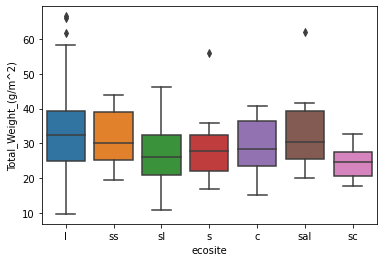

In [35]:
sns.boxplot(x='ecosite', y='Total_Weight_(g/m^2)', data=df_fire_fnl)

<AxesSubplot:xlabel='site', ylabel='Total_Weight_(g/m^2)'>

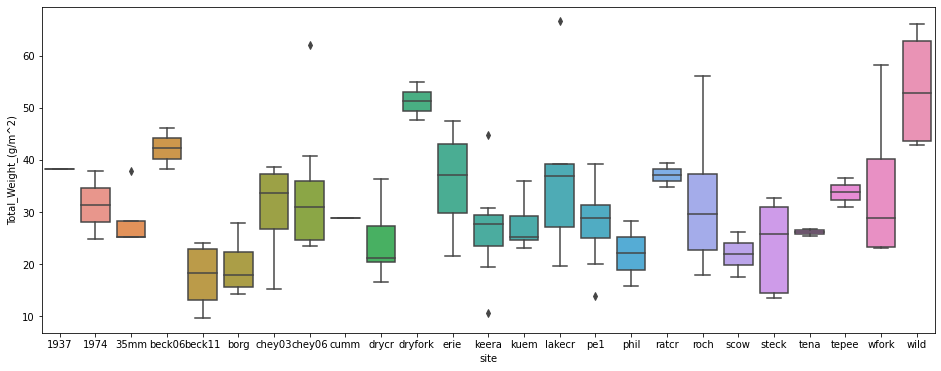

In [36]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='site', y='Total_Weight_(g/m^2)', data=df_fire_fnl)

<AxesSubplot:xlabel='loc', ylabel='Total_Weight_(g/m^2)'>

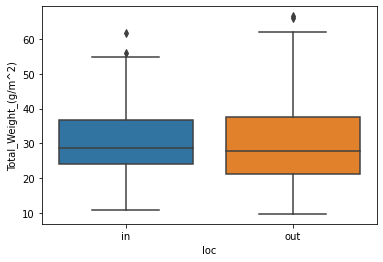

In [37]:
sns.boxplot(x='loc', y='Total_Weight_(g/m^2)', data=df_fire_fnl)